 # Astro Trading Pipeline - Modular Research Notebook



 This is the **central orchestrating notebook** that imports and runs all modules.



 ## Pipeline Steps:

 1. Setup & Config

 2. Load Market Data (from PostgreSQL)

 3. Visualize Price

 4. Create Labels (balanced UP/DOWN)

 5. Compute Astro Data

 6. Build Features

 7. Train Model

 8. Evaluate & Visualize

 9. (Optional) Grid Search

 10. Save Model

 ## 0. Environment Check

In [109]:
# Check dependencies
import importlib.util as iu

required = ["xgboost", "sklearn", "matplotlib", "seaborn", "tqdm", "pyarrow", "psycopg2", "swisseph"]
missing = [pkg for pkg in required if iu.find_spec(pkg) is None]

if missing:
    print("Missing packages:", ", ".join(missing))
    print("Install with: conda install -c conda-forge " + " ".join(missing))
else:
    print("✓ All dependencies found")


✓ All dependencies found


 ## 1. Setup & Configuration

In [110]:
# Import RESEARCH modules
import sys
from pathlib import Path

# Find project root and add to path
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT: {PROJECT_ROOT}")


PROJECT_ROOT: /home/rut/ostrofun


In [111]:
# Import all modules
from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data, get_latest_date, get_data_paths
from RESEARCH.labeling import create_balanced_labels, gaussian_smooth_centered
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates,
    calculate_aspects_for_dates,
    calculate_transits_for_dates,
    get_natal_bodies,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
    get_feature_inventory,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    tune_threshold,
    predict_with_threshold,
    evaluate_model,
    get_feature_importance,
    check_cuda_available,
)
from RESEARCH.visualization import (
    plot_price_distribution,
    plot_class_distribution,
    plot_price_with_labels,
    plot_last_n_days,
    plot_confusion_matrix,
    plot_feature_importance,
    plot_predictions,
)

print("✓ All RESEARCH modules imported")


✓ All RESEARCH modules imported


In [112]:
# Show configuration
print(f"Active subject: {cfg.active_subject_id}")
print(f"Data root: {cfg.data_root}")
print(f"DB URL configured: {bool(cfg.db_url)}")
print(f"Label config: {cfg.get_label_config()}")


Active subject: btc
Data root: /home/rut/ostrofun/data/market
DB URL configured: True
Label config: {'horizon': 1, 'target_move_share': 0.5, 'gauss_window': 201, 'gauss_std': 50.0, 'price_mode': 'raw'}


 ## 2. Load Market Data

In [113]:
# Load market data from database
df_market = load_market_data()

# Optional: filter by start date
DATA_START = "2017-11-01"
df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)

print(f"\nMarket data: {len(df_market)} rows")
print(f"Date range: {df_market['date'].min().date()} → {df_market['date'].max().date()}")
df_market.head()


Loaded 5677 rows from DB for subject=btc
Date range: 2010-07-18 -> 2026-01-31

Market data: 3014 rows
Date range: 2017-11-01 → 2026-01-31


/home/rut/ostrofun/RESEARCH/data_loader.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,date,close
0,2017-11-01,6737.8
1,2017-11-02,7024.8
2,2017-11-03,7152.1
3,2017-11-04,7363.8
4,2017-11-05,7389.5


 ## 3. Visualize Price

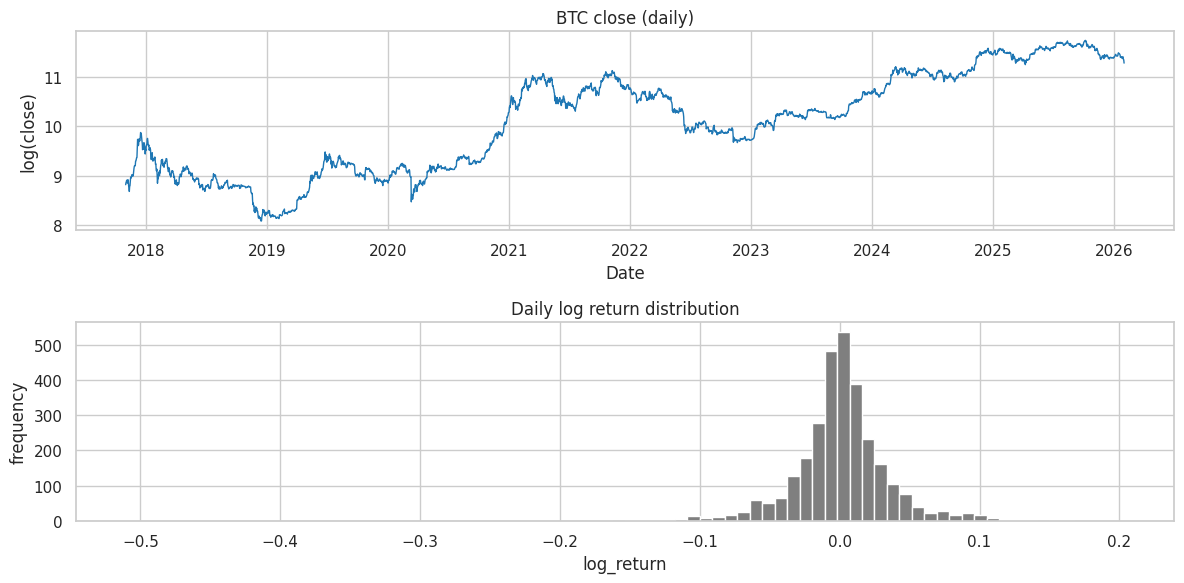

In [114]:
# Price and return distribution
plot_price_distribution(df_market, price_mode="log")


 ## 4. Create Labels

In [115]:
# Configuration for labeling
LABEL_CONFIG = {
    "horizon": 1,           # Prediction horizon (days)
    "move_share": 0.5,      # Total share of samples to keep
    "gauss_window": 201,    # Gaussian window for detrending (odd)
    "gauss_std": 50.0,      # Gaussian std
    "price_mode": "raw",    # 'raw' or 'log'
    "label_mode": "balanced_detrended",
}

# Create balanced labels
df_labels = create_balanced_labels(
    df_market,
    horizon=LABEL_CONFIG["horizon"],
    move_share=LABEL_CONFIG["move_share"],
    gauss_window=LABEL_CONFIG["gauss_window"],
    gauss_std=LABEL_CONFIG["gauss_std"],
    price_mode=LABEL_CONFIG["price_mode"],
    label_mode=LABEL_CONFIG["label_mode"],
)

df_labels.head()


Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30


,date,close,target
0,2017-11-05,7389.5,0
1,2017-11-08,7444.4,0
2,2017-11-09,7129.6,0
3,2017-11-11,6339.9,0
4,2017-11-12,5878.1,1


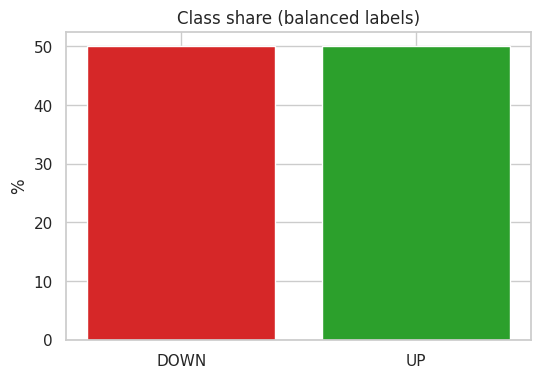

In [116]:
# Class distribution
plot_class_distribution(df_labels)


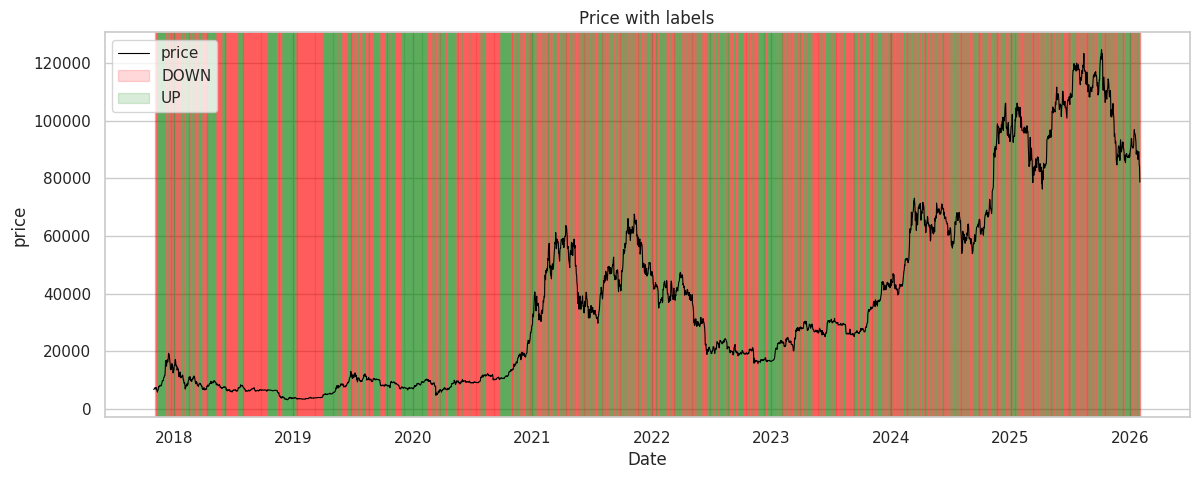

In [117]:
# Price with labels
plot_price_with_labels(df_market, df_labels, price_mode="raw")


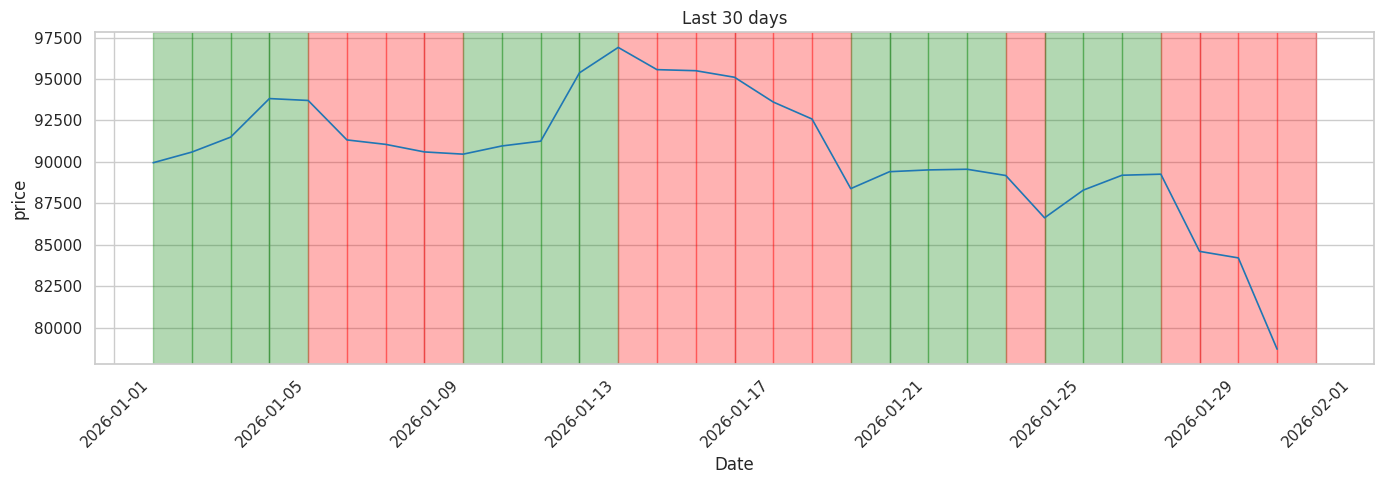

Last 30 days: 30 labeled (forward-filled) out of 30


In [118]:
# Last 30 days
plot_last_n_days(df_market, df_labels, n_days=30)


 ## 5. Compute Astro Data

In [119]:
# Initialize ephemeris
settings = init_ephemeris()
print(f"Bodies: {[b.name for b in settings.bodies]}")
print(f"Aspects: {[a.name for a in settings.aspects]}")


Bodies: ['Sun', 'Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'TrueNode', 'MeanNode', 'Lilith']
Aspects: ['Conjunction', 'Sextile', 'Square', 'Trine', 'Opposition']


In [120]:
# Calculate body positions for all dates
# (This is fast - no need to cache)
df_bodies, bodies_by_date = calculate_bodies_for_dates(
    df_market["date"],
    settings,
    progress=True,
)

print(f"\nBodies calculated: {len(df_bodies)} rows")
df_bodies.head()


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 11631.73it/s]


Bodies calculated: 39182 rows


,date,body,lon,lat,speed,is_retro,sign,declination
0,2017-11-01,Sun,218.755657,-0.000011,1.000008,False,Scorpio,-0.000011
1,2017-11-01,Moon,356.209228,-2.907350,13.493332,False,Pisces,-2.907350
2,2017-11-01,Mercury,232.905646,-1.409936,1.497015,False,Scorpio,-1.409936
3,2017-11-01,Venus,201.888931,1.488282,1.249436,False,Libra,1.488282
4,2017-11-01,Mars,185.828074,1.137132,0.631064,False,Libra,1.137132


In [121]:
# Calculate aspects
ORB_MULTIPLIER = 0.25  # Best from grid search (tight aspects)

df_aspects = calculate_aspects_for_dates(
    bodies_by_date,
    settings,
    orb_mult=ORB_MULTIPLIER,
    progress=True,
)

print(f"\nAspects: {len(df_aspects)} rows")
df_aspects.head()


Calculating aspects (orb=0.25): 100%|██████████| 3014/3014 [00:00<00:00, 51860.77it/s]



Aspects: 14088 rows


,date,p1,p2,aspect,orb,is_exact,is_applying
0,2017-11-01,TrueNode,MeanNode,Conjunction,0.873850,False,True
1,2017-11-02,TrueNode,MeanNode,Conjunction,0.812445,False,True
2,2017-11-03,Sun,Neptune,Trine,0.816923,False,True
3,2017-11-03,Moon,Venus,Opposition,0.274432,False,False
4,2017-11-03,Moon,Saturn,Trine,0.684597,False,False


 ## 6. Build Features

In [122]:
# Build feature matrix
df_features = build_full_features(
    df_bodies,
    df_aspects,
    df_transits=None,  # Add transit aspects if needed
    include_pair_aspects=True,
    include_transit_aspects=False,
    exclude_bodies=["Uranus", "Pluto"],  # Best from grid search - these add noise
)

print(f"Features shape: {df_features.shape}")
df_features.head()


Features shape: (3014, 556)


,date,Jupiter_lon,Lilith_lon,Mars_lon,MeanNode_lon,Mercury_lon,Moon_lon,Neptune_lon,Saturn_lon,Sun_lon,TrueNode_lon,Venus_lon,Jupiter_speed,Lilith_speed,Mars_speed,MeanNode_speed,Mercury_speed,Moon_speed,Neptune_speed,Saturn_speed,Sun_speed,TrueNode_speed,Venus_speed,Jupiter_is_retro,Lilith_is_retro,Mars_is_retro,MeanNode_is_retro,Mercury_is_retro,Moon_is_retro,Neptune_is_retro,Saturn_is_retro,Sun_is_retro,TrueNode_is_retro,Venus_is_retro,Jupiter_declination,Lilith_declination,Mars_declination,MeanNode_declination,Mercury_declination,Moon_declination,Neptune_declination,Saturn_declination,Sun_declination,TrueNode_declination,Venus_declination,Jupiter_sign_idx,Lilith_sign_idx,Mars_sign_idx,MeanNode_sign_idx,Mercury_sign_idx,Moon_sign_idx,Neptune_sign_idx,Saturn_sign_idx,Sun_sign_idx,TrueNode_sign_idx,Venus_sign_idx,aspect_hit_Jupiter__Lilith__Sextile,aspect_hit_Jupiter__Lilith__Square,aspect_hit_Jupiter__Lilith__Trine,aspect_hit_Jupiter__Mars__Conjunction,aspect_hit_Jupiter__Mars__Opposition,aspect_hit_Jupiter__Mars__Sextile,aspect_hit_Jupiter__Mars__Square,aspect_hit_Jupiter__Mars__Trine,aspect_hit_Jupiter__MeanNode__Conjunction,aspect_hit_Jupiter__MeanNode__Opposition,aspect_hit_Jupiter__MeanNode__Sextile,aspect_hit_Jupiter__MeanNode__Square,aspect_hit_Jupiter__MeanNode__Trine,aspect_hit_Jupiter__Mercury__Conjunction,aspect_hit_Jupiter__Mercury__Opposition,aspect_hit_Jupiter__Mercury__Sextile,aspect_hit_Jupiter__Mercury__Square,aspect_hit_Jupiter__Mercury__Trine,aspect_hit_Jupiter__Moon__Conjunction,aspect_hit_Jupiter__Moon__Opposition,aspect_hit_Jupiter__Moon__Sextile,aspect_hit_Jupiter__Moon__Square,aspect_hit_Jupiter__Moon__Trine,aspect_hit_Jupiter__Neptune__Conjunction,aspect_hit_Jupiter__Neptune__Sextile,aspect_hit_Jupiter__Neptune__Square,aspect_hit_Jupiter__Neptune__Trine,aspect_hit_Jupiter__Saturn__Conjunction,aspect_hit_Jupiter__Saturn__Sextile,aspect_hit_Jupiter__Saturn__Square,aspect_hit_Jupiter__Saturn__Trine,aspect_hit_Jupiter__Sun__Conjunction,aspect_hit_Jupiter__Sun__Opposition,aspect_hit_Jupiter__Sun__Sextile,aspect_hit_Jupiter__Sun__Square,aspect_hit_Jupiter__Sun__Trine,aspect_hit_Jupiter__TrueNode__Conjunction,aspect_hit_Jupiter__TrueNode__Opposition,aspect_hit_Jupiter__TrueNode__Sextile,aspect_hit_Jupiter__TrueNode__Square,aspect_hit_Jupiter__TrueNode__Trine,aspect_hit_Jupiter__Venus__Conjunction,aspect_hit_Jupiter__Venus__Opposition,aspect_hit_Jupiter__Venus__Sextile,aspect_hit_Jupiter__Venus__Square,aspect_hit_Jupiter__Venus__Trine,aspect_hit_Lilith__Mars__Conjunction,aspect_hit_Lilith__Mars__Opposition,aspect_hit_Lilith__Mars__Sextile,aspect_hit_Lilith__Mars__Square,aspect_hit_Lilith__Mars__Trine,aspect_hit_Lilith__MeanNode__Conjunction,aspect_hit_Lilith__MeanNode__Opposition,aspect_hit_Lilith__MeanNode__Sextile,aspect_hit_Lilith__MeanNode__Square,aspect_hit_Lilith__MeanNode__Trine,aspect_hit_Lilith__Mercury__Conjunction,aspect_hit_Lilith__Mercury__Opposition,aspect_hit_Lilith__Mercury__Sextile,aspect_hit_Lilith__Mercury__Square,aspect_hit_Lilith__Mercury__Trine,aspect_hit_Lilith__Moon__Conjunction,aspect_hit_Lilith__Moon__Opposition,aspect_hit_Lilith__Moon__Sextile,aspect_hit_Lilith__Moon__Square,aspect_hit_Lilith__Moon__Trine,aspect_hit_Lilith__Neptune__Conjunction,aspect_hit_Lilith__Neptune__Opposition,aspect_hit_Lilith__Neptune__Sextile,aspect_hit_Lilith__Neptune__Square,aspect_hit_Lilith__Neptune__Trine,aspect_hit_Lilith__Saturn__Opposition,aspect_hit_Lilith__Saturn__Sextile,aspect_hit_Lilith__Saturn__Square,aspect_hit_Lilith__Saturn__Trine,aspect_hit_Lilith__Sun__Conjunction,aspect_hit_Lilith__Sun__Opposition,aspect_hit_Lilith__Sun__Sextile,aspect_hit_Lilith__Sun__Square,aspect_hit_Lilith__Sun__Trine,aspect_hit_Lilith__TrueNode__Conjunction,aspect_hit_Lilith__TrueNode__Opposition,aspect_hit_Lilith__TrueNode__Sextile,aspect_hit_Lilith__TrueNode__Square,aspect_hit_Lilith__TrueNode__Trine,aspect_hit_Lilith__Venus__Conjunction,aspect_hit_Lilith__Venus__Opposition,aspect_hit_Lilith__Venus__Sextile,aspec

In [123]:
# Merge with labels
df_dataset = merge_features_with_labels(df_features, df_labels)
print(f"\nDataset shape: {df_dataset.shape}")


Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 555

Dataset shape: (3010, 557)


In [124]:
# Feature inventory
feature_inventory = get_feature_inventory(df_dataset)
print("\nFeature groups:")
print(feature_inventory.groupby("group").size())



Feature groups:
group
Jupiter       5
Lilith        5
Mars          5
MeanNode      5
Mercury       5
Moon          5
Neptune       5
Saturn        5
Sun           5
TrueNode      5
Venus         5
aspect      500
dtype: int64


 ## 7. Train Model

In [125]:
# Check CUDA availability
use_cuda, device = check_cuda_available()
print(f"Using device: {device}")


Using device: cuda


In [126]:
# Split dataset (time-based)
train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)

print(f"Train: {train_df['date'].min().date()} → {train_df['date'].max().date()}")
print(f"Val:   {val_df['date'].min().date()} → {val_df['date'].max().date()}")
print(f"Test:  {test_df['date'].min().date()} → {test_df['date'].max().date()}")


Split: Train=2107, Val=451, Test=452
Train: 2017-11-05 → 2023-08-12
Val:   2023-08-13 → 2024-11-05
Test:  2024-11-06 → 2026-01-31


In [127]:
# Prepare X, y
feature_cols = get_feature_columns(df_dataset)
X_train, y_train = prepare_xy(train_df, feature_cols)
X_val, y_val = prepare_xy(val_df, feature_cols)
X_test, y_test = prepare_xy(test_df, feature_cols)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")


X_train: (2107, 555), y_train: (2107,)
X_val:   (451, 555), y_val:   (451,)
X_test:  (452, 555), y_test:  (452,)


In [128]:
# Train XGBoost model
MODEL_PARAMS = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

model = train_xgb_model(
    X_train, y_train,
    X_val, y_val,
    feature_cols,
    n_classes=2,
    device=device,
    **MODEL_PARAMS,
)


In [129]:
# Tune threshold on validation set
# ТЕПЕРЬ по умолчанию оптимизирует recall_min (качество худшего класса)
best_threshold, best_score = tune_threshold(model, X_val, y_val)  # metric="recall_min" по умолчанию


🎯 Best threshold=0.50, RECALL_MIN=0.4314, gap=0.1395


 ## 8. Evaluate & Visualize

In [130]:
# Predict on test set
y_pred = predict_with_threshold(model, X_test, threshold=best_threshold)

# Evaluate
results = evaluate_model(y_test, y_pred, label_names=["DOWN", "UP"])



=== Model Evaluation ===
Accuracy: 0.5155
Balanced Accuracy: 0.5158
MCC: 0.0321
F1 Macro: 0.5126
Summary Score: 0.5142

Majority Baseline: acc=0.5022, bal_acc=0.5000
Prev-Label Baseline: acc=0.5708, bal_acc=0.5708

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.51      0.60      0.55       225
          UP       0.52      0.44      0.47       227

    accuracy                           0.52       452
   macro avg       0.52      0.52      0.51       452
weighted avg       0.52      0.52      0.51       452

95% Bootstrap CI:
  acc: [0.4733, 0.5575]
  bal_acc: [0.4744, 0.5550]
  f1_macro: [0.4696, 0.5525]


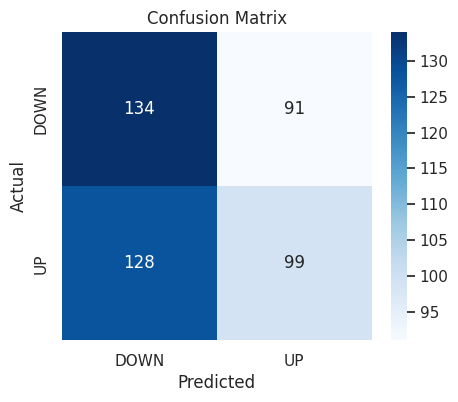

In [131]:
# Confusion matrix
plot_confusion_matrix(y_test, y_pred)


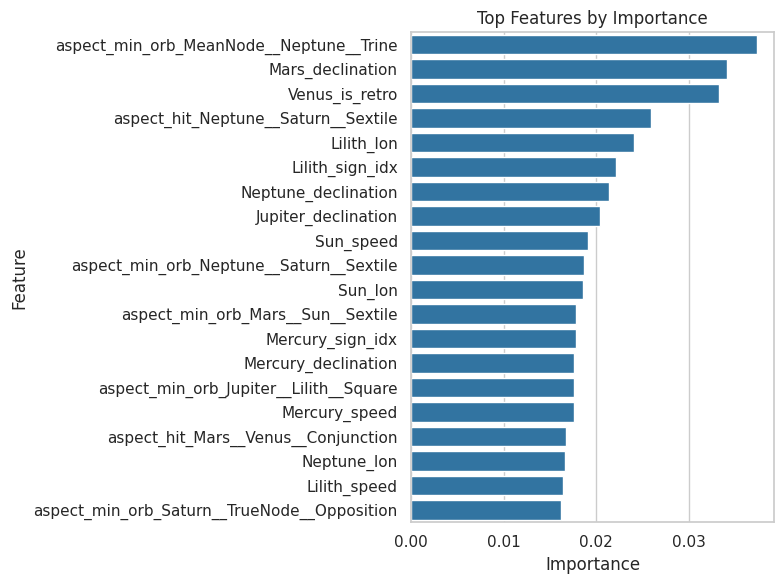

In [132]:
# Feature importance
imp_df = get_feature_importance(model, feature_cols, top_n=20)
plot_feature_importance(imp_df)


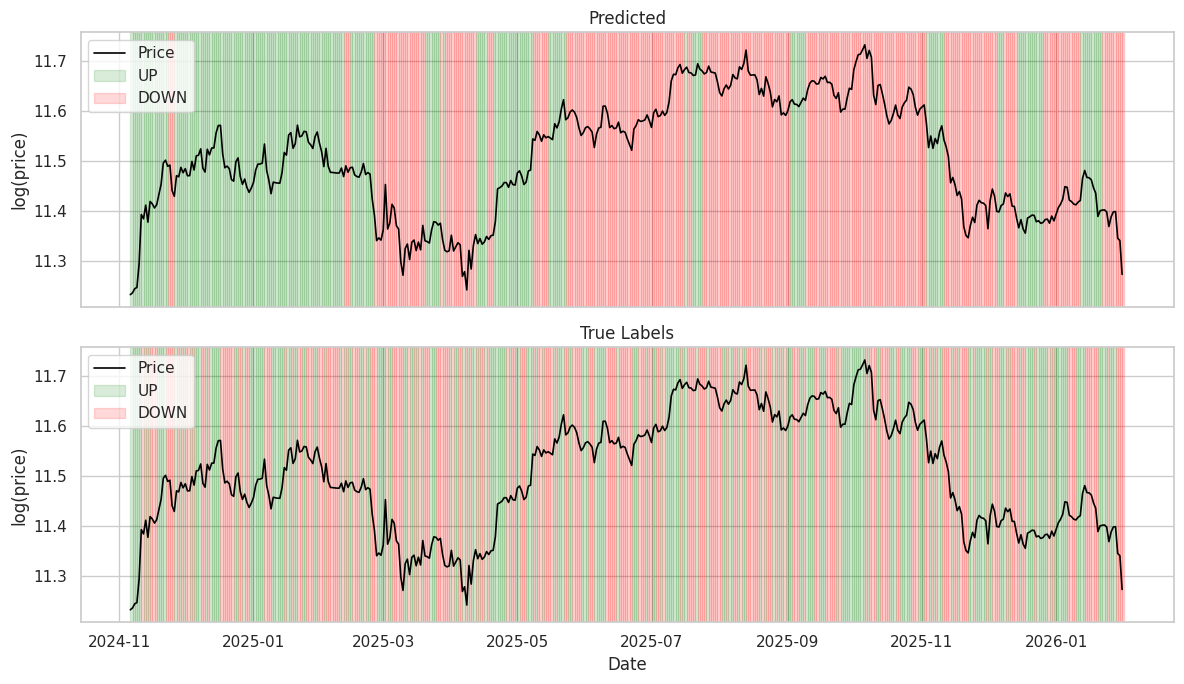

In [133]:
# Predictions on test set
# Теперь df_dataset уже содержит все дни с forward-filled метками
# Нужно только добавить close для визуализации
import pandas as pd  # На случай если запускается отдельно

test_df_plot = test_df.copy()
test_df_plot["date"] = pd.to_datetime(test_df_plot["date"])
test_df_plot = test_df_plot.merge(
    df_market[["date", "close"]].assign(date=lambda x: pd.to_datetime(x["date"])), 
    on="date", 
    how="left"
)

plot_predictions(test_df_plot, y_pred, y_true=y_test, price_mode="log")


 ## 9. (Optional) Grid Search



 Выберите один из вариантов ниже:

 - **run_grid_search** — основной поиск (coord + gauss + orb)

 - **run_full_grid_search** — полный поиск с body ablation

 - **run_body_ablation_search** — только ablation тел

In [134]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🔬 PARAMETER GRID SEARCH — ПЕРЕБОР ВСЕХ ПАРАМЕТРОВ
# ══════════════════════════════════════════════════════════════════════════════════
#
# Этот ноутбук позволяет ЛЕГКО менять параметры поиска:
# - Орбис множители (насколько точные аспекты)
# - Окна Гаусса (масштаб тренда)
# - Std Гаусса (резкость перехода)
# - Режим координат (geo/helio/both)
# - Какие тела исключать
#
# ══════════════════════════════════════════════════════════════════════════════════

from RESEARCH.grid_search import GridSearchConfig, run_grid_search, evaluate_combo
from RESEARCH.astro_engine import init_ephemeris, calculate_bodies_for_dates_multi, precompute_angles_for_dates
from RESEARCH.model_training import check_cuda_available
from itertools import product

# Инициализация
settings = init_ephemeris()
_, device = check_cuda_available()
print(f"🖥️ Устройство: {device}")


🖥️ Устройство: cuda


In [135]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🎛️ НАСТРОЙКИ ПОИСКА — МЕНЯЙТЕ ЗДЕСЬ!
# ══════════════════════════════════════════════════════════════════════════════════

# 📊 BASELINE для сравнения
BASELINE = {
    "R_MIN": 0.578,
    "GAP": 0.004,
    "MCC": 0.159,
    "config": "geo O=0.25 W=201 S=50.0 -[Uranus,Pluto]"
}

# ──────────────────────────────────────────────────────────────────────────────
# 🌍 РЕЖИМ КООРДИНАТ — выберите один или несколько
# ──────────────────────────────────────────────────────────────────────────────
# "geo"   = геоцентрические (классическая астрология)
# "helio" = гелиоцентрические (научная астрономия)  
# "both"  = оба режима объединены (больше признаков)

COORD_MODES = ["geo", "helio", "both"]  # ← ПЕРЕБРАТЬ ВСЕ ТРИ

# ──────────────────────────────────────────────────────────────────────────────
# 🔮 ОРБ МНОЖИТЕЛИ — насколько точные аспекты ловить
# ──────────────────────────────────────────────────────────────────────────────
# 0.25 = очень узкие орбисы (только точные аспекты)
# 0.5  = узкие орбисы
# 1.0  = стандартные орбисы
# 1.5  = широкие орбисы (больше аспектов, больше шума)

ORB_MULTIPLIERS = [0.1, 0.15, 0.2, 0.25,0.35]  # ← ШИРОКИЙ ДИАПАЗОН

# ──────────────────────────────────────────────────────────────────────────────
# 📈 ОКНА ГАУССА — масштаб тренда в днях
# ──────────────────────────────────────────────────────────────────────────────
# 51  = ~2.5 месяца (краткосрочные тренды)
# 101 = ~5 месяцев
# 151 = ~7.5 месяцев
# 201 = ~10 месяцев (долгосрочные тренды)
# 301 = ~15 месяцев (очень долго)

GAUSS_WINDOWS = [51, 101, 151, 201, 251,300]  # ← РАСШИРЕННЫЙ ДИАПАЗОН

# ──────────────────────────────────────────────────────────────────────────────
# 🔔 ШИРИНА ГАУССА — резкость переходов UP/DOWN
# ──────────────────────────────────────────────────────────────────────────────
# 20  = резкие переходы (чувствителен к шуму)
# 50  = средние переходы
# 80  = плавные переходы
# 100 = очень плавные

GAUSS_STDS = [20.0, 35.0, 50.0, 70.0, 90.0]  # ← РАСШИРЕННЫЙ ДИАПАЗОН

# ──────────────────────────────────────────────────────────────────────────────
# 🚫 ИСКЛЮЧАЕМЫЕ ТЕЛА — какие планеты убрать из анализа
# ──────────────────────────────────────────────────────────────────────────────
EXCLUDE_BODIES = None  # ← Не исключаем тела (используем все 11)

# ──────────────────────────────────────────────────────────────────────────────
# ⚙️ ПАРАМЕТРЫ МОДЕЛИ
# ──────────────────────────────────────────────────────────────────────────────
MODEL_PARAMS = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.03,
}

# ──────────────────────────────────────────────────────────────────────────────
# Подсчёт комбинаций
# ──────────────────────────────────────────────────────────────────────────────
total_combos = len(COORD_MODES) * len(ORB_MULTIPLIERS) * len(GAUSS_WINDOWS) * len(GAUSS_STDS)

print("=" * 80)
print("🔬 PARAMETER GRID SEARCH")
print("=" * 80)
print(f"""
📊 BASELINE для сравнения:
   R_MIN = {BASELINE['R_MIN']:.3f}
   GAP   = {BASELINE['GAP']:.3f}
   MCC   = {BASELINE['MCC']:.3f}
   Config: {BASELINE['config']}

🎛️ Параметры для перебора:
   • Coord modes:    {COORD_MODES}
   • Orb multipliers: {ORB_MULTIPLIERS}
   • Gauss windows:  {GAUSS_WINDOWS}
   • Gauss stds:     {GAUSS_STDS}
   • Excluded bodies: {EXCLUDE_BODIES}

📈 Всего комбинаций: {total_combos}
   При ~51 расч/мин это займёт ~{total_combos/51:.1f} минут
""")


🔬 PARAMETER GRID SEARCH

📊 BASELINE для сравнения:
   R_MIN = 0.578
   GAP   = 0.004
   MCC   = 0.159
   Config: geo O=0.25 W=201 S=50.0 -[Uranus,Pluto]

🎛️ Параметры для перебора:
   • Coord modes:    ['geo', 'helio', 'both']
   • Orb multipliers: [0.1, 0.15, 0.2, 0.25, 0.35]
   • Gauss windows:  [51, 101, 151, 201, 251, 300]
   • Gauss stds:     [20.0, 35.0, 50.0, 70.0, 90.0]
   • Excluded bodies: None

📈 Всего комбинаций: 450
   При ~51 расч/мин это займёт ~8.8 минут



In [136]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🚀 ЗАПУСК GRID SEARCH
# ══════════════════════════════════════════════════════════════════════════════════

results = []
best_so_far = {"R_MIN": 0, "combo": None}

# Предварительный расчёт позиций для всех coord_modes
print("\n📍 Предварительный расчёт позиций...")
cached_bodies = {}
cached_angles = {}

for coord_mode in COORD_MODES:
    print(f"   Computing {coord_mode}...")
    df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
        df_market["date"], settings, coord_mode=coord_mode, progress=False
    )
    bodies_by_date = geo_by_date if geo_by_date else helio_by_date
    cached_bodies[coord_mode] = (df_bodies, geo_by_date, helio_by_date)
    
    print(f"   Computing angles for {coord_mode}...")
    cached_angles[coord_mode] = precompute_angles_for_dates(bodies_by_date, progress=False)

print("✓ Кэш готов!\n")

# Генерируем все комбинации
combos = list(product(COORD_MODES, ORB_MULTIPLIERS, GAUSS_WINDOWS, GAUSS_STDS))
print(f"🔢 Всего комбинаций: {len(combos)}")
print("=" * 80)

for i, (coord_mode, orb, gw, gs) in enumerate(combos):
    params_str = f"[{i+1}/{len(combos)}] {coord_mode} O={orb} W={gw} S={gs}"
    
    try:
        df_bodies, geo_by_date, helio_by_date = cached_bodies[coord_mode]
        bodies_by_date = geo_by_date if geo_by_date else helio_by_date
        
        res = evaluate_combo(
            df_market, df_bodies, bodies_by_date, settings,
            orb, gw, gs,
            exclude_bodies=EXCLUDE_BODIES,
            angles_cache=cached_angles.get(coord_mode),
            device=device,
            model_params=MODEL_PARAMS,
        )
        res["coord_mode"] = coord_mode
        res["orb_mult"] = orb
        res["gauss_window"] = gw
        res["gauss_std"] = gs
        results.append(res)
        
        if "error" not in res:
            r_min = res['recall_min']
            mcc = res['mcc']
            
            # Update best
            if r_min > best_so_far["R_MIN"]:
                best_so_far["R_MIN"] = r_min
                best_so_far["combo"] = f"{coord_mode} O={orb} W={gw} S={gs}"
                best_so_far["MCC"] = mcc
            
            print(f"{params_str:<45} → R_MIN={r_min:.3f} MCC={mcc:.3f}")
            print(f"   🏆 BEST: R_MIN={best_so_far['R_MIN']:.3f} ({best_so_far['combo']})")
        else:
            print(f"{params_str:<45} → ERROR: {res.get('error')}")
            
    except Exception as e:
        print(f"{params_str:<45} → CRASH: {e}")
        results.append({
            "coord_mode": coord_mode, "orb_mult": orb, 
            "gauss_window": gw, "gauss_std": gs, "error": str(e)
        })



📍 Предварительный расчёт позиций...
   Computing geo...
   Computing angles for geo...
   Computing helio...
   Computing angles for helio...
   Computing both...
   Computing angles for both...
✓ Кэш готов!

🔢 Всего комбинаций: 450
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 767
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.50, RECALL_MIN=0.3535, gap=0.3457
[1/450] geo O=0.1 W=51 S=20.0                 → R_MIN=0.427 MCC=0.066
   🏆 BEST: R_MIN=0.427 (geo O=0.1 W=51 S=20.0)
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 767
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.50, RECALL_MIN=0.2925, gap=0.4356
[2/450] geo O=0.1 W=51 S=35.0                 → R_MIN=0.399 MCC=-0.035
   🏆 BEST: R_MIN=0.427 (geo O=0.1 W=51 S=20.0)

In [137]:
# RESULTS — сравнение с BASELINE
print("\n" + "=" * 80)
print("📊 RESULTS: PARAMETER GRID SEARCH vs BASELINE")
print("=" * 80)

print(f"""
📌 BASELINE для сравнения:
   R_MIN = {BASELINE['R_MIN']:.3f}
   GAP   = {BASELINE['GAP']:.3f}  
   MCC   = {BASELINE['MCC']:.3f}
   Config: {BASELINE['config']}
""")

results_df = pd.DataFrame(results)

if "recall_min" in results_df.columns:
    # Добавляем delta относительно baseline
    results_df["delta_R_MIN"] = results_df["recall_min"] - BASELINE["R_MIN"]
    results_df["delta_MCC"] = results_df["mcc"] - BASELINE["MCC"]
    
    # Сортируем по recall_min
    results_df = results_df.sort_values("recall_min", ascending=False).reset_index(drop=True)
    
    # Топ-20 результатов
    print("\n🏆 TOP 20 BEST COMBINATIONS:")
    print("-" * 90)
    print(f"{'#':<3} {'Coord':<6} {'Orb':<6} {'Win':<5} {'Std':<5} {'R_MIN':<7} {'Δ R_MIN':<9} {'MCC':<7} {'Status':<10}")
    print("-" * 90)
    
    for i, row in results_df.head(20).iterrows():
        if "error" in row and pd.notna(row.get("error")):
            continue
            
        delta_r = row.get("delta_R_MIN", 0)
        coord = row.get("coord_mode", "?")
        orb = row.get("orb_mult", 0)
        win = row.get("gauss_window", 0)
        std = row.get("gauss_std", 0)
        
        if delta_r > 0:
            status = "✅ BETTER"
        elif delta_r > -0.02:
            status = "🟡 ~SAME"
        else:
            status = "❌ WORSE"
        
        print(f"{i+1:<3} {coord:<6} {orb:<6} {win:<5} {std:<5.0f} {row['recall_min']:<7.3f} {delta_r:<+9.3f} {row['mcc']:<7.3f} {status:<10}")
    
    print("-" * 90)
    print(f"{'---':<3} {'BASE':<6} {'0.25':<6} {'201':<5} {'50':<5} {BASELINE['R_MIN']:<7.3f} {'---':<9} {BASELINE['MCC']:<7.3f}")
    
    # Анализ по coord_mode
    print("\n📊 SUMMARY BY COORD_MODE:")
    for cm in COORD_MODES:
        subset = results_df[results_df["coord_mode"] == cm]
        if not subset.empty:
            best_r = subset["recall_min"].max()
            avg_r = subset["recall_min"].mean()
            print(f"   {cm:6}: best R_MIN={best_r:.3f}, avg={avg_r:.3f}")

# Save
out_path = PROJECT_ROOT / "data" / "market" / "reports" / "param_grid_results.csv"
results_df.to_csv(out_path, index=False)
print(f"\n💾 Results saved: {out_path}")

# Best overall
if not results_df.empty and "recall_min" in results_df.columns:
    best = results_df.iloc[0]
    delta = best['recall_min'] - BASELINE['R_MIN']
    print(f"\n🏆 BEST COMBINATION:")
    print(f"   Coord:  {best.get('coord_mode', '?')}")
    print(f"   Orb:    {best.get('orb_mult', '?')}")
    print(f"   Window: {best.get('gauss_window', '?')}")
    print(f"   Std:    {best.get('gauss_std', '?')}")
    print(f"   R_MIN = {best['recall_min']:.3f} (Δ {delta:+.3f} vs baseline)")
    print(f"   MCC   = {best['mcc']:.3f}")
    
    if delta > 0:
        print(f"\n   🎯 NEW BEST found! Beats baseline by {delta:+.3f}!")
    else:
        print(f"\n   ⚠️ No combination beats the baseline.")



📊 RESULTS: PARAMETER GRID SEARCH vs BASELINE

📌 BASELINE для сравнения:
   R_MIN = 0.578
   GAP   = 0.004  
   MCC   = 0.159
   Config: geo O=0.25 W=201 S=50.0 -[Uranus,Pluto]


🏆 TOP 20 BEST COMBINATIONS:
------------------------------------------------------------------------------------------
#   Coord  Orb    Win   Std   R_MIN   Δ R_MIN   MCC     Status    
------------------------------------------------------------------------------------------
1   both   0.2    300   70    0.587   +0.009    0.177   ✅ BETTER  
2   both   0.15   300   70    0.587   +0.009    0.182   ✅ BETTER  
3   geo    0.1    151   90    0.562   -0.016    0.128   🟡 ~SAME   
4   both   0.2    151   70    0.559   -0.019    0.169   🟡 ~SAME   
5   both   0.2    201   90    0.556   -0.022    0.142   ❌ WORSE   
6   both   0.25   201   90    0.556   -0.022    0.146   ❌ WORSE   
7   both   0.15   201   90    0.556   -0.022    0.146   ❌ WORSE   
8   geo    0.15   151   50    0.553   -0.025    0.128   ❌ WORSE   
9   geo 

In [138]:
# BODY ABLATION ONLY (uncomment to run)
# Use current params, test all body exclusion combinations

# from RESEARCH.grid_search import run_body_ablation_search
# 
# ablation_df = run_body_ablation_search(
#     df_market,
#     orb_mult=ORB_MULTIPLIER,
#     gauss_window=LABEL_CONFIG["gauss_window"],
#     gauss_std=LABEL_CONFIG["gauss_std"],
#     max_exclude=3,  # Try removing up to 3 bodies
# )


 ## 10. Save Model

In [139]:
# Save model
from joblib import dump

artifact_dir = PROJECT_ROOT / "models_artifacts"
artifact_dir.mkdir(parents=True, exist_ok=True)

artifact = {
    "model": model.model,
    "scaler": model.scaler,
    "feature_names": feature_cols,
    "threshold": best_threshold,
    "config": {
        "label_config": LABEL_CONFIG,
        "orb_multiplier": ORB_MULTIPLIER,
        "model_params": MODEL_PARAMS,
    },
}

out_path = artifact_dir / f"xgb_astro_research.joblib"
dump(artifact, out_path)
print(f"✓ Model saved: {out_path}")


✓ Model saved: /home/rut/ostrofun/models_artifacts/xgb_astro_research.joblib


 ---

 ## Summary



 This modular pipeline makes it easy to:

 - **Debug**: Each module can be tested independently

 - **Extend**: Add new features, models, or visualizations

 - **Experiment**: Quickly try different configurations



 ### TODO:

 - [ ] Add moon phases to features

 - [ ] Grid search for astro body exclusion

 - [ ] Add houses for birth date grid search

 - [ ] Save best grid search results